# 01 - ECT | Spectral Parameterization

---

In this notebook, we use the spectral parameterization method (FOOOF/specparam) to extract spectral parameters from the power spectra of 22 subjects pre- and post-ECT treatment.

### Imports & load data

In [2]:
import mne
import numpy as np
import pandas as pd
from fooof import FOOOFGroup
from fooof import FOOOF
from fooof.analysis import get_band_peak_fg
from fooof.utils import trim_spectrum

%matplotlib inline

### Settings

In [3]:
# PSD computation settings
FMAX = 100
N_FFT = 4000
N_OVERLAP = 2000

# SpecParam (FOOOF) settings
MODEL_SETTINGS = {'peak_width_limits':[1, 8],
                    'min_peak_height':0.05,
                    'max_n_peaks':12,
                    'aperiodic_mode': "fixed"}
FREQ_RANGE = [0.5,30]

# Define frequency bands
DELTA = [1,4]
THETA = [4,7]
ALPHA = [7,12]

### Functions

In [4]:
# Defining a function to get the cannonical power in a frequency band
def get_band_pow(freqs, spectra, band):
    """get average power in frequency band in spectrum
    Parameters
    ----------
    freqs : 1d array
        Frequency values
    spectra : 1d array
        Power spectrum power values
    band : list of [float, float]
        Band definition
    Returns
    -------
    band_pow : float
        average power in band
    """
    trim_freqs, trim_pows = trim_spectrum(freqs, spectra, f_range=band)
    band_pow = np.mean(trim_pows, axis=1)
    
    return band_pow

## 1. Single subject ECT specparam demo

First we will parameterize the spectra of one subject with 60 channels to vizualize the data and get some insights into how best to fit the model.

In [6]:
pre_path = '/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_PRE_REST_EC.fif'
post_path = '/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_POST_REST_EC.fif'

In [7]:
eeg_pre = mne.io.read_raw_fif(pre_path);
eeg_post = mne.io.read_raw_fif(post_path);

Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/3325033656.py:1: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_pre = mne.io.read_raw_fif(pre_path);


    Range : 0 ... 603279 =      0.000 ...   603.279 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/3325033656.py:2: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_post = mne.io.read_raw_fif(post_path);


    Range : 0 ... 601879 =      0.000 ...   601.879 secs
Ready.


### Plot power spectra

Effective window size : 2.048 (s)


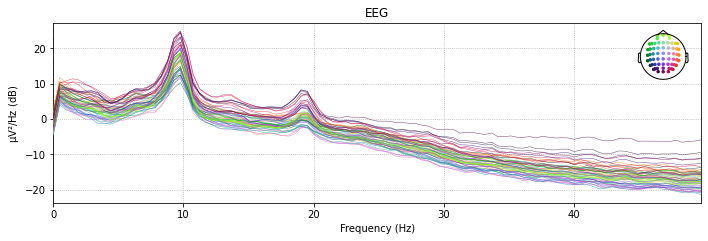

In [8]:
eeg_pre.plot_psd(fmax=50);

Effective window size : 2.048 (s)


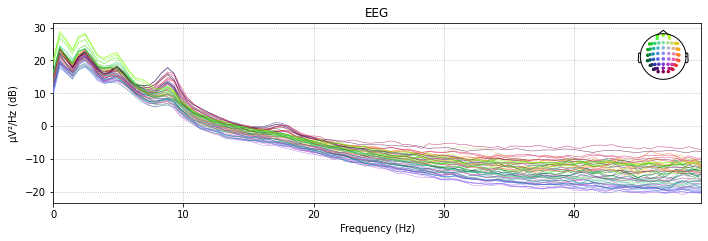

In [9]:
eeg_post.plot_psd(fmax=50);

### Compute PSDs

In [10]:
single_psds_pre, single_freqs_pre = mne.time_frequency.psd_welch(eeg_pre, fmin=0, fmax=FMAX, n_fft=N_FFT,
                                 n_overlap=N_OVERLAP, n_per_seg=None,average='mean', window='hamming')
single_psds_post, single_freqs_post = mne.time_frequency.psd_welch(eeg_post, fmin=0, fmax=FMAX, n_fft=N_FFT,
                                 n_overlap=N_OVERLAP, n_per_seg=None,average='mean', window='hamming')

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


### SpecParam Group results

In [11]:
fg_pre = FOOOFGroup(**MODEL_SETTINGS)
fg_post = FOOOFGroup(**MODEL_SETTINGS)

fg_pre.fit(single_freqs_pre, single_psds_pre, freq_range=FREQ_RANGE)
fg_post.fit(single_freqs_post, single_psds_post, freq_range=FREQ_RANGE)

Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.


/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


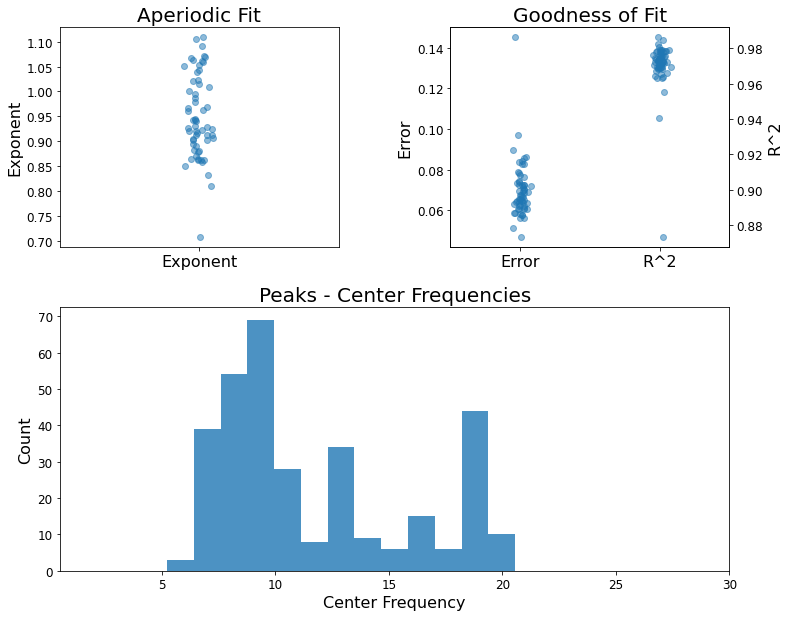

In [12]:
fg_pre.plot()

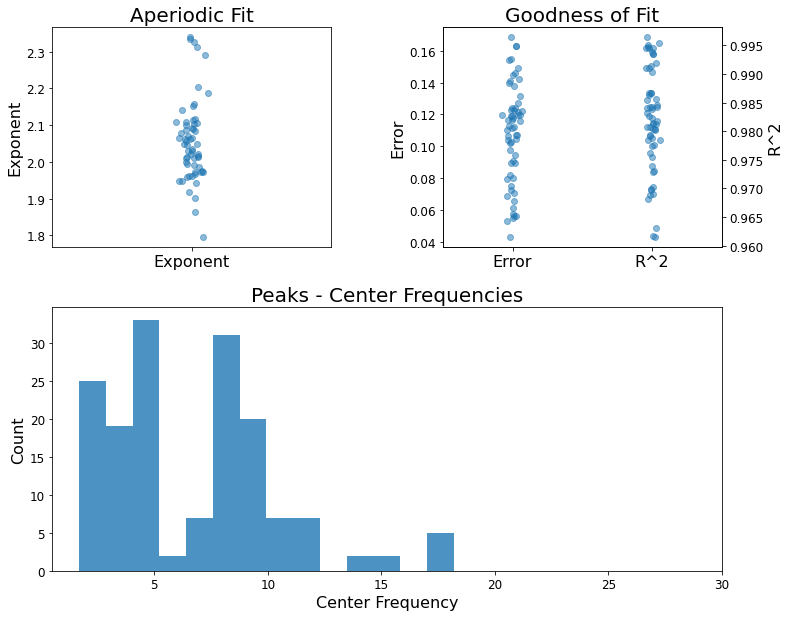

In [13]:
fg_post.plot()

### Single model Specparam results

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 30 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.2100, 0.9516                                         
                                                                                                  
                                       7 peaks were found:                                        
          

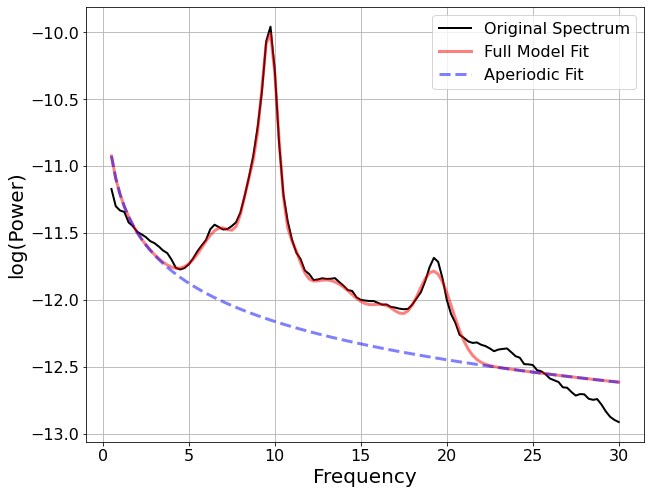

In [14]:
fm = FOOOF(**MODEL_SETTINGS)
fm.report(single_freqs_pre, single_psds_pre.mean(axis=0), freq_range=FREQ_RANGE)

---
## 2. Full ECT dataset

### a. Compute PSDs

In [17]:
big_dat_path = '/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/'# Path to data

all_channels_pre = []
all_channels_post = []
all_patients = ['002', '003', '004', '010', '013', '016', '018', '019', '025', '029', 
                '031', '033', '034', '035', '038', '039', '040', '047', '048', '050', '053', '054', '055'] # List of patients
n_patients = len(all_patients)

# Shape of saved data: (# of patients, # of channels, # of frequency axis values)
pre_psd = np.zeros((n_patients, single_psds_pre.shape[0], single_psds_pre.shape[1])) # Could also use single_psds_post
post_psd = np.zeros((n_patients, single_psds_pre.shape[0], single_psds_pre.shape[1])) 


for count, patient in enumerate(all_patients):
    
    # Load data
    file_name_post = 'ECT' + patient + "_POST_REST_EC.fif"
    file_name_pre = 'ECT' + patient + "_PRE_REST_EC.fif"
    eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)  
    eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)
    
    # Only pick EEG channels
    eeg_data_post.pick_types(eeg=True)
    eeg_data_pre.pick_types(eeg=True)
    
    all_channels_pre.append(eeg_data_pre.info['ch_names'])
    all_channels_post.append(eeg_data_post.info['ch_names'])

    # Create PSDs
    # psds.shape --> [60 channels, 401 frequencies]
    psds_post, freqs_post = mne.time_frequency.psd_welch(eeg_data_post, fmin=0, fmax=FMAX, n_fft=N_FFT,
                                 n_overlap=N_OVERLAP, n_per_seg=None,average='mean', window='hamming')
    psds_pre, freqs_pre = mne.time_frequency.psd_welch(eeg_data_pre, fmin=0, fmax=FMAX, n_fft=N_FFT,
                                 n_overlap=N_OVERLAP, n_per_seg=None,average='mean', window='hamming')

    # Save PSDs in single data structure
    post_psd[count, :, :] = psds_post # [patients, 60 channels, 401 frequencies]
    pre_psd[count, :, :] = psds_pre # [patients, 60 channels, 401 frequencies]

Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 649199 =      0.000 ...   649.199 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT002_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 537919 =      0.000 ...   537.919 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT003_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT003_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 601279 =      0.000 ...   601.279 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT003_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT003_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 602479 =      0.000 ...   602.479 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT004_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT004_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 674359 =      0.000 ...   674.359 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT004_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT004_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 623759 =      0.000 ...   623.759 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT010_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT010_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 602359 =      0.000 ...   602.359 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT010_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT010_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 632399 =      0.000 ...   632.399 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT013_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT013_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 602479 =      0.000 ...   602.479 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT013_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT013_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 608079 =      0.000 ...   608.079 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT016_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT016_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 627519 =      0.000 ...   627.519 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT016_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT016_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 631719 =      0.000 ...   631.719 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT018_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT018_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 602879 =      0.000 ...   602.879 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT018_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT018_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 602879 =      0.000 ...   602.879 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT019_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT019_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 653959 =      0.000 ...   653.959 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT019_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT019_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 611319 =      0.000 ...   611.319 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT025_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT025_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 620519 =      0.000 ...   620.519 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT025_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT025_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 629759 =      0.000 ...   629.759 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT029_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT029_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 601439 =      0.000 ...   601.439 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT029_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT029_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 634919 =      0.000 ...   634.919 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT031_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT031_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 631239 =      0.000 ...   631.239 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT031_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT031_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 648879 =      0.000 ...   648.879 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT033_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT033_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 613879 =      0.000 ...   613.879 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT033_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT033_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 713519 =      0.000 ...   713.519 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT034_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT034_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 618959 =      0.000 ...   618.959 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT034_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT034_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 648759 =      0.000 ...   648.759 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT035_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT035_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 610999 =      0.000 ...   610.999 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT035_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT035_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 586679 =      0.000 ...   586.679 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT038_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT038_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 639719 =      0.000 ...   639.719 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT038_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT038_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 617839 =      0.000 ...   617.839 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT039_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT039_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 626799 =      0.000 ...   626.799 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT039_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT039_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 606159 =      0.000 ...   606.159 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT040_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT040_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 625599 =      0.000 ...   625.599 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT040_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT040_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 612519 =      0.000 ...   612.519 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT047_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT047_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 607839 =      0.000 ...   607.839 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT047_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT047_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 612279 =      0.000 ...   612.279 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT048_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT048_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 607399 =      0.000 ...   607.399 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT048_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT048_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 635639 =      0.000 ...   635.639 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT050_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT050_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 817439 =      0.000 ...   817.439 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT050_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT050_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 600359 =      0.000 ...   600.359 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT053_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT053_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 601839 =      0.000 ...   601.839 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT053_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT053_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 601519 =      0.000 ...   601.519 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT054_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT054_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 598559 =      0.000 ...   598.559 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT054_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT054_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 600359 =      0.000 ...   600.359 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_POST_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:19: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_POST_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_post = mne.io.read_raw(big_dat_path + file_name_post)


    Range : 0 ... 601879 =      0.000 ...   601.879 secs
Ready.
Opening raw data file /Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_PRE_REST_EC.fif...


/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_70561/1679113044.py:20: RuntimeWarning: This filename (/Volumes/VLabA/ect_mst/DATA/clean_ECT_unfilt/ECT055_PRE_REST_EC.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  eeg_data_pre = mne.io.read_raw(big_dat_path + file_name_pre)


    Range : 0 ... 603279 =      0.000 ...   603.279 secs
Ready.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


In [18]:
# Save pre and post_psd's as numpy
np.save('../saved_files/ect_files/pre_ect_psd.npy', pre_psd)
np.save('../saved_files/ect_files/post_ect_psd.npy', post_psd)
np.save('../saved_files/ect_files/freq_axis.npy', freqs_pre)


In [19]:
# Check if the channels are all the same for each patient (PRE & POST)
channel_match_pre = []
for count, ind in enumerate(all_channels_pre):
    channel_match_pre.append(np.sum(all_channels_pre[0] == all_channels_pre[count]))
                             
channel_match_post = []
for count, ind in enumerate(all_channels_post):
    channel_match_post.append(np.sum(all_channels_post[0] == all_channels_post[count]))

In [22]:
# Should be a list of 1's
assert all(channel_match_pre)

In [23]:
# Should be a list of 1's
assert all(channel_match_post)

### b. Fit FOOOFGroup and extract parameters

In [24]:
# Load in data
pre_psd = np.load('../saved_files/ect_files/pre_ect_psd.npy')
post_psd = np.load('../saved_files/ect_files/post_ect_psd.npy')
freqs = np.load('../saved_files/ect_files/freq_axis.npy')

In [25]:
fg_pre = FOOOFGroup(**MODEL_SETTINGS)
fg_post = FOOOFGroup(**MODEL_SETTINGS)

In [26]:
# Create variables for running over patients
all_patients = ['002', '003', '004', '010', '013', '016', '018', '019', '025', '029', 
                '031', '033', '034', '035', '038', '039', '040', '047', '048', '050', '053', '054', '055']
n_patients = len(all_patients)

# Tile patient and channel lists (to go into dictionaries)
channels = np.tile(['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2',
 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7',
 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2',
 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5',
 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'O1', 'OZ', 'O2'], n_patients)  # repeating this list for pre/post dictionaries
patient_list = np.repeat(all_patients, pre_psd.shape[1]) # 60 because len of channels, repeating this list for pre/post dictionaries
pre_list = np.tile('pre', pre_psd.shape[1]*n_patients)
post_list = np.tile('post', pre_psd.shape[1]*n_patients)

# Initialize empty lists
delta_pre_amp = [] # Peak amplitude above aperiodic signal
delta_pre_cf = [] # Center frequency
delta_pre_bw = [] # Bandwidth
delta_pre_bp = [] # Canonnical band power

delta_post_amp = []
delta_post_cf = []
delta_post_bw = []
delta_post_bp = []

theta_pre_amp = []
theta_pre_cf = []
theta_pre_bw = []
theta_pre_bp = []

theta_post_amp = []
theta_post_cf = []
theta_post_bw = []
theta_post_bp = []

alpha_pre_amp = []
alpha_pre_cf = []
alpha_pre_bw = []
alpha_pre_bp = []

alpha_post_amp = []
alpha_post_cf = []
alpha_post_bw = []
alpha_post_bp = []

fits_pre = np.zeros((n_patients, pre_psd.shape[1], 119))  # 119 is the frequency axis for the model frequency range
fits_post = np.zeros((n_patients, pre_psd.shape[1], 119))

offset_pre = []
knee_pre = []
exponent_pre = []

offset_post = []
knee_post = []
exponent_post = []

error_pre = []
r_squared_pre = []

error_post = []
r_squared_post = []

for count, patient in enumerate(all_patients):

#     [patients, 60 channels, 401 frequencies]
    fg_pre.fit(freqs, pre_psd[count,:,:], freq_range = FREQ_RANGE, n_jobs=-1)
    fg_post.fit(freqs, post_psd[count,:,:], freq_range = FREQ_RANGE,  n_jobs=-1)
    
    periodic_delta_pre = get_band_peak_fg(fg_pre, DELTA)  # periodic params (amp, cf, bandwidth)
    periodic_theta_pre = get_band_peak_fg(fg_pre, THETA)  # periodic params (amp, cf, bandwidth)
    periodic_alpha_pre = get_band_peak_fg(fg_pre, ALPHA)  # periodic params (amp, cf, bandwidth)
    
    periodic_delta_post = get_band_peak_fg(fg_post, DELTA)  # periodic params (amp, cf, bandwidth)
    periodic_theta_post = get_band_peak_fg(fg_post, THETA)  # periodic params (amp, cf, bandwidth)
    periodic_alpha_post = get_band_peak_fg(fg_post, ALPHA)  # periodic params (amp, cf, bandwidth)
    
    aperiodic_pre = fg_pre.get_params('aperiodic_params')  # get the aperiodic 1/f properties (offset, knee, exp)
    aperiodic_post = fg_post.get_params('aperiodic_params')  # get the aperiodic 1/f properties (offset, knee, exp)

    all_errors_pre = fg_pre.get_params('error')
    all_errors_post = fg_post.get_params('error')
    
    all_r_squared_pre = fg_pre.get_params('r_squared')
    all_r_squared_post = fg_post.get_params('r_squared')    
    
    # Concatenate parameters
    # DELTA
    delta_pre_cf = np.concatenate([delta_pre_cf, periodic_delta_pre[:,0]])
    delta_pre_amp = np.concatenate([delta_pre_amp, periodic_delta_pre[:,1]])
    delta_pre_bw = np.concatenate([delta_pre_bw, periodic_delta_pre[:,2]])
    delta_pre_bp = np.concatenate([delta_pre_bp, np.log10(get_band_pow(freqs, pre_psd[count,:,:], DELTA))])
    delta_post_cf = np.concatenate([delta_post_cf, periodic_delta_post[:,0]])
    delta_post_amp = np.concatenate([delta_post_amp, periodic_delta_post[:,1]])
    delta_post_bw = np.concatenate([delta_post_bw, periodic_delta_post[:,2]])
    delta_post_bp = np.concatenate([delta_post_bp, np.log10(get_band_pow(freqs, post_psd[count,:,:], DELTA))])
    
    # THETA
    theta_pre_cf = np.concatenate([theta_pre_cf, periodic_theta_pre[:,0]])
    theta_pre_amp = np.concatenate([theta_pre_amp, periodic_theta_pre[:,1]])
    theta_pre_bw = np.concatenate([theta_pre_bw, periodic_theta_pre[:,2]])
    theta_pre_bp = np.concatenate([theta_pre_bp, np.log10(get_band_pow(freqs, pre_psd[count,:,:], THETA))])
    theta_post_cf = np.concatenate([theta_post_cf, periodic_theta_post[:,0]])
    theta_post_amp = np.concatenate([theta_post_amp, periodic_theta_post[:,1]])
    theta_post_bw = np.concatenate([theta_post_bw, periodic_theta_post[:,2]])
    theta_post_bp = np.concatenate([theta_post_bp, np.log10(get_band_pow(freqs, post_psd[count,:,:], THETA))])
    
    # ALPHA
    alpha_pre_cf = np.concatenate([alpha_pre_cf, periodic_alpha_pre[:,0]])
    alpha_pre_amp = np.concatenate([alpha_pre_amp, periodic_alpha_pre[:,1]])
    alpha_pre_bw = np.concatenate([alpha_pre_bw, periodic_alpha_pre[:,2]])
    alpha_pre_bp = np.concatenate([alpha_pre_bp, np.log10(get_band_pow(freqs, pre_psd[count,:,:], ALPHA))])
    alpha_post_cf = np.concatenate([alpha_post_cf, periodic_alpha_post[:,0]])
    alpha_post_amp = np.concatenate([alpha_post_amp, periodic_alpha_post[:,1]])
    alpha_post_bw = np.concatenate([alpha_post_bw, periodic_alpha_post[:,2]])
    alpha_post_bp = np.concatenate([alpha_post_bp, np.log10(get_band_pow(freqs, post_psd[count,:,:], ALPHA))])
    
    # APERIODIC
    offset_pre = np.concatenate([offset_pre, aperiodic_pre[:,0]])
    exponent_pre = np.concatenate([exponent_pre, aperiodic_pre[:,1]])
    offset_post = np.concatenate([offset_post, aperiodic_post[:,0]])
    exponent_post = np.concatenate([exponent_post, aperiodic_post[:,1]])

    # GOODNESS OF FIT MEASURES
    error_pre = np.concatenate([error_pre, all_errors_pre])
    error_post = np.concatenate([error_post, all_errors_post])
    r_squared_pre = np.concatenate([r_squared_pre, all_r_squared_pre])
    r_squared_post = np.concatenate([r_squared_post, all_r_squared_post])
    
    # Store model fits for plotting
    for channel in np.arange(0,pre_psd.shape[1]):
        fits_pre[count, channel, :] = fg_pre.get_fooof(channel).fooofed_spectrum_
        fits_post[count, channel, :] = fg_post.get_fooof(channel).fooofed_spectrum_


Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.


/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 power spectra.
Running FOOOFGroup across 60 pow

### Save SpecParam output into a dataframe

#### Identify bad fits for exclusion

In [27]:
# Add column to df for exclusions
# Excluding all with low r_squared
pre_exclude = r_squared_pre < 0.8
post_exclude = r_squared_post < 0.8

exclude_list = []
for row in np.arange(0, len(pre_exclude)):
    exclude_list.append(pre_exclude[row] or post_exclude[row])

In [28]:
# Create dictionary
headers_list_pre = ['patient', 'pre_post', 'channel', 'delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 
                    'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 
                    'alpha_bp','offset', 'exponent', 'error', 'r_squared', 'exclude']
headers_list_post = ['patient', 'pre_post', 'channel', 'delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 
                    'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 
                    'alpha_bp','offset', 'exponent', 'error', 'r_squared', 'exclude']
variables_list_pre = [patient_list, pre_list, channels, delta_pre_cf, delta_pre_bw, delta_pre_amp, delta_pre_bp,
                     theta_pre_cf, theta_pre_bw, theta_pre_amp, theta_pre_bp, alpha_pre_cf, alpha_pre_bw, alpha_pre_amp,
                    alpha_pre_bp, offset_pre, exponent_pre, error_pre, r_squared_pre, exclude_list]
variables_list_post = [patient_list, post_list, channels, delta_post_cf, delta_post_bw, delta_post_amp, delta_post_bp,
                     theta_post_cf, theta_post_bw, theta_post_amp, theta_post_bp, alpha_post_cf, alpha_post_bw, 
                       alpha_post_amp, alpha_post_bp, offset_post, exponent_post, error_post, r_squared_post, exclude_list]

exp_pre_dict = dict(zip(headers_list_pre, variables_list_pre))
exp_post_dict = dict(zip(headers_list_post, variables_list_post))

In [29]:
# Save dictionary as pandas
exp_pre_df = pd.DataFrame(exp_pre_dict)
exp_post_df = pd.DataFrame(exp_post_dict)

exp_df = pd.concat([exp_pre_df, exp_post_df], axis=0, ignore_index=True)

In [30]:
# Exclude Patient 002 for excessive noise
exp_df.loc[exp_df.patient=='002', 'exclude'] = True

# Save pandas df as csv
exp_df.to_csv('../saved_files/ect_files/ect_all_features.csv') # <-- save without patient 002
# exp_df.to_csv('../saved_files/all_features_with_002.csv') # <-- save with patient 002

In [31]:
# Save model fits
np.save('../saved_files/ect_files/fits_pre', fits_pre)
np.save('../saved_files/ect_files/fits_post', fits_post)